# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

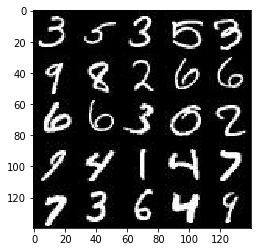

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

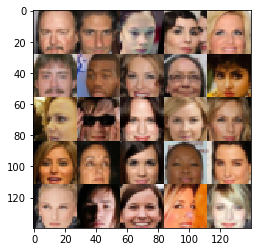

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    alpha = 0.1
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    losses = []
    _,image_width,image_height,image_channels = data_shape
    input_real, input_z , _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate, beta1)
    steps = 0
    n_images = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.7916... Generator Loss: 17.7739
Epoch 1/2... Discriminator Loss: 7.6268... Generator Loss: 0.0005
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 12.3298
Epoch 1/2... Discriminator Loss: 2.3468... Generator Loss: 11.6641
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 1.4508
Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 1.5998
Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 0.4937... Generator Loss: 2.3495
Epoch 1/2... Discriminator Loss: 1.4962... Generator Loss: 3.6208
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 1.7987


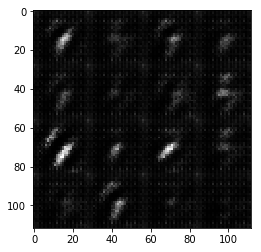

Epoch 1/2... Discriminator Loss: 1.5499... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 1.7329
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.7134
Epoch 1/2... Discriminator Loss: 1.5809... Generator Loss: 2.3098
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 1.6048
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 1.4167
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 1.1647
Epoch 1/2... Discriminator Loss: 1.2236... Generator Loss: 1.5538
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 1.5159
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 1.2856


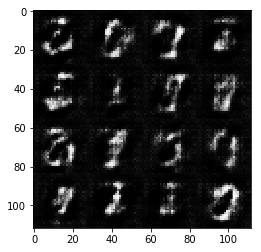

Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 1.0691
Epoch 1/2... Discriminator Loss: 1.5187... Generator Loss: 1.4277
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 0.9579
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 1.8463
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 1.4172
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 1.1498
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 1.2113
Epoch 1/2... Discriminator Loss: 1.4555... Generator Loss: 1.6052
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 1.4278
Epoch 1/2... Discriminator Loss: 1.1176... Generator Loss: 1.1088


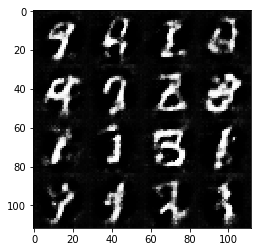

Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.5156
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.4666
Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.4228
Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.3889
Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 0.4395
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 0.3548
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 0.5099


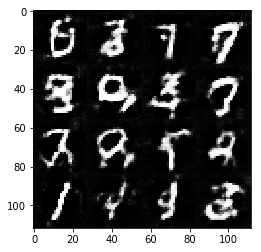

Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.5460
Epoch 1/2... Discriminator Loss: 1.4635... Generator Loss: 0.3539
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.4380
Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 0.5307
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.3911
Epoch 1/2... Discriminator Loss: 1.2728... Generator Loss: 0.4784
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.5751
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.5699
Epoch 2/2... Discriminator Loss: 1.2362... Generator Loss: 0.5512
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.4991


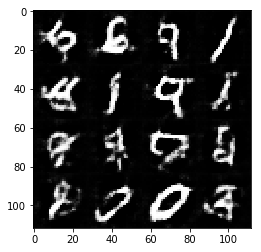

Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.5504
Epoch 2/2... Discriminator Loss: 1.2355... Generator Loss: 0.5375
Epoch 2/2... Discriminator Loss: 1.1751... Generator Loss: 0.6105
Epoch 2/2... Discriminator Loss: 2.1201... Generator Loss: 0.1526
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 0.8412
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.7190
Epoch 2/2... Discriminator Loss: 1.1481... Generator Loss: 1.0665
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 0.9741
Epoch 2/2... Discriminator Loss: 1.5391... Generator Loss: 1.4618
Epoch 2/2... Discriminator Loss: 1.1594... Generator Loss: 0.8522


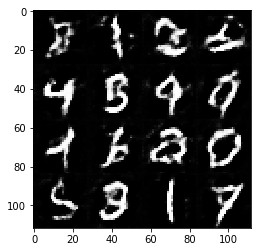

Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 1.2831
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 1.3077
Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.1572... Generator Loss: 0.6000
Epoch 2/2... Discriminator Loss: 2.3134... Generator Loss: 0.1250
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 1.3981
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 1.5459
Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 0.8517


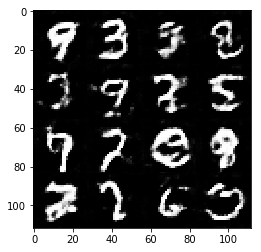

Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.5062
Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 1.1048
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 1.0391
Epoch 2/2... Discriminator Loss: 1.1152... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 1.7223... Generator Loss: 1.6071
Epoch 2/2... Discriminator Loss: 1.1376... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 0.5642
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 0.3343
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.3739


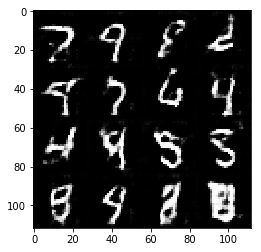

Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 0.6048
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.7133
Epoch 2/2... Discriminator Loss: 1.7973... Generator Loss: 0.2253
Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.5362
Epoch 2/2... Discriminator Loss: 2.1879... Generator Loss: 0.1479
Epoch 2/2... Discriminator Loss: 1.1280... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 1.8710... Generator Loss: 1.7646
Epoch 2/2... Discriminator Loss: 1.0563... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.4381


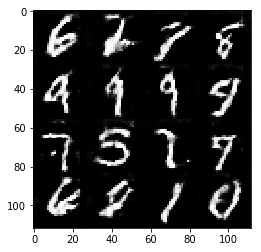

Epoch 2/2... Discriminator Loss: 1.1615... Generator Loss: 0.5813
Epoch 2/2... Discriminator Loss: 1.3591... Generator Loss: 0.3849
Epoch 2/2... Discriminator Loss: 1.5114... Generator Loss: 0.3488


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 4.2771... Generator Loss: 0.0202
Epoch 1/1... Discriminator Loss: 3.7529... Generator Loss: 0.0328
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 1.9633... Generator Loss: 8.9034
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 2.8069
Epoch 1/1... Discriminator Loss: 0.2805... Generator Loss: 2.7974
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.4182
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 1.6635
Epoch 1/1... Discriminator Loss: 0.2984... Generator Loss: 2.2056


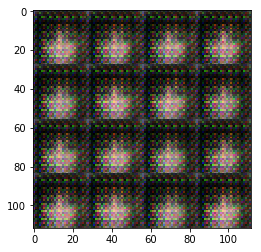

Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 2.9805
Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 5.6618
Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 2.3659
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 2.4623
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.6824


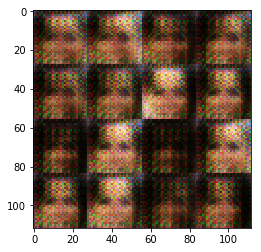

Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.8340... Generator Loss: 0.2680
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 1.7699... Generator Loss: 0.4113
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.6375


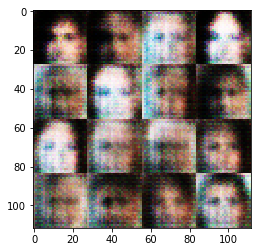

Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 1.2774
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 1.9187
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 1.5653
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.5897


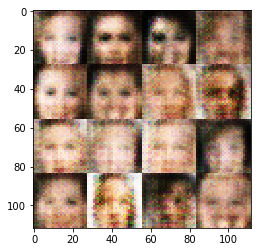

Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 0.3137
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.6857... Generator Loss: 0.3053


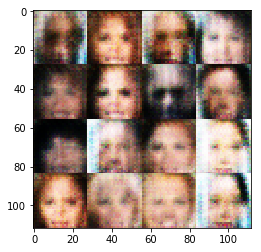

Epoch 1/1... Discriminator Loss: 1.6972... Generator Loss: 0.3068
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.8012... Generator Loss: 0.2506
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.4727
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 2.2411... Generator Loss: 0.1566
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 2.1926
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.8326
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.2315


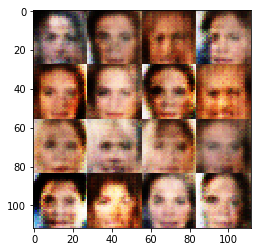

Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 2.1041
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.9671... Generator Loss: 2.5566
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.3726
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 1.9570
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.7023
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.9930


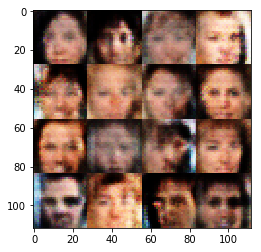

Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.3161
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.3233
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 2.4060
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 3.6065
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.0817


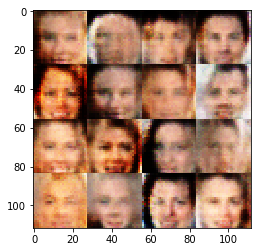

Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 2.0752
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.7705
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.0489


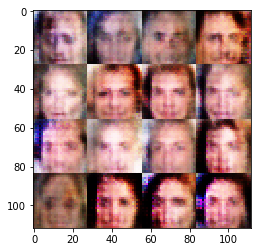

Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.3639
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 1.7106
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8668


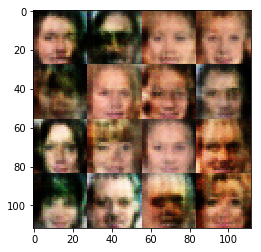

Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 1.9602... Generator Loss: 2.2950
Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 0.2955
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.7168
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.0715


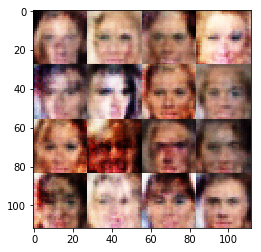

Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.2908
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.9374


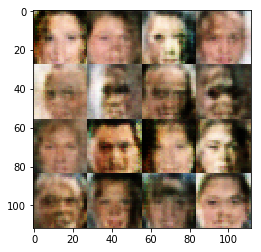

Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 2.1190
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.6405


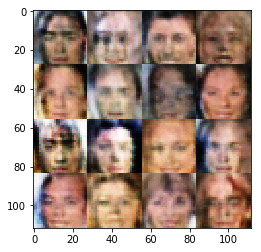

Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.7786
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 2.3842


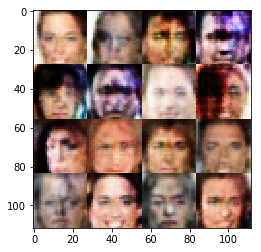

Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 1.6249
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.0716


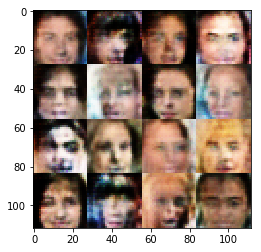

Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.8795... Generator Loss: 0.2261
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 1.0407


In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。